In [1]:
import numpy as np # Successfully installed numpy-1.23.5
import pandas as pd # Successfully installed pandas-1.3.5
import matplotlib.pyplot as plt
import seaborn as sns
import os
import networkx as nx

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool
import sys
from torch_geometric.nn import GATConv
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split

# Add the parent directory to the system path
# sys.path.append(os.path.abspath('..'))
# from models import GNN
# the temporal package is not available TODO: find what the issue is
# from torch_geometric_temporal.nn.recurrent import A3TGCN2 # torch-geometric-temporal 0.54.0 requires pandas<=1.3.5, but you have pandas 2.2.3 which is incompatible.
#from torch_geometric_temporal.signal import temporal_signal_split
# import 
# Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
# from stellargraph import StellarGraph
# import custom functions from utils.py
# from utils import *
# os.getcwd() # double check current working directory

In [2]:
# .. goes up one level in directory
path = r'../datasets/Car-Hacking Dataset/Fuzzy_dataset.csv'
# path = r'../datasets/Car-Hacking Dataset/DoS_dataset.csv'
# path = r'../datasets/Car-Hacking Dataset/gear_dataset.csv'
# path = r'../datasets/Car-Hacking Dataset/RPM_dataset.csv'
columns = ['Timestamp', 'CAN ID','DLC','Data1','Data2','Data3','Data4','Data5','Data6','Data7','Data8', 'label'] 
df = pd.read_csv(path, names=columns, delimiter=',')

In [3]:
df

,Timestamp,CAN ID,DLC,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,label
0,1.478196e+09,0545,8,d8,00,00,8a,00,00,00,00,R
1,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
2,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
3,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
4,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
...,...,...,...,...,...,...,...,...,...,...,...,...
3838855,1.478201e+09,018f,8,fe,59,00,00,00,41,00,00,R
3838856,1.478201e+09,0260,8,18,21,21,30,08,8f,6d,19,R
3838857,1.478201e+09,02a0,8,24,00,9a,1d,97,02,bd,00,R
3838858,1.478201e+09,0329,8,dc,b7,7f,14,11,20,00,14,R


In [98]:
'''
Temporal graph dataset: a graph that changes over time
Graph type: Homogeneous graph
Nodes: CAN ID
Edges: The next CAN ID in the sequence
Node Features (optional): The data in the CAN ID

Steps:
1. identify node properties
2. Edges: How to connect nodes?
3. Extract labels

Convert to pytorch geometric format
One graph to another graph: 200 messages to 1 graph

There is also pytorch geometric temporal package

# build a baseline model RF, SVM, etc

# fraud datasets may have incorrect labels -> use label smoothing
Featureless nodes: use random numbers

make a GCN that uses labels only, and one that takes an average of data form its neighbors as well
Graph Attention Networks (GAT)

Idea: could I use FL on the different car datasets, share those weights and perhaps it could generalize better. A practical use case would be between different companies, where they don't want to share their data
but it is in their best interest to have the best performing cybersecurity model.

https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html
'''

"\nTemporal graph dataset: a graph that changes over time\nGraph type: Homogeneous graph\nNodes: CAN ID\nEdges: The next CAN ID in the sequence\nNode Features (optional): The data in the CAN ID\n\nSteps:\n1. identify node properties\n2. Edges: How to connect nodes?\n3. Extract labels\n\nConvert to pytorch geometric format\nOne graph to another graph: 200 messages to 1 graph\n\nThere is also pytorch geometric temporal package\n\n# build a baseline model RF, SVM, etc\n\n# fraud datasets may have incorrect labels -> use label smoothing\nFeatureless nodes: use random numbers\n\nmake a GCN that uses labels only, and one that takes an average of data form its neighbors as well\nGraph Attention Networks (GAT)\n\nIdea: could I use FL on the different car datasets, share those weights and perhaps it could generalize better. A practical use case would be between different companies, where they don't want to share their data\nbut it is in their best interest to have the best performing cybersecur

In [5]:
def hex_to_decimal(x):
    if x is None or x == 'None':
        return None
    try:
        return int(x, 16)
    except (ValueError, TypeError):
        return x
    

def pad_row(row):
    if row['DLC'] != 8:
        # grab the label
        label = row['Data'+str(row['DLC']+1)]
        row['Data'+str(row['DLC']+1)] = '00'
        row['label'] = label

    row.fillna(value='00', inplace=True) # Fill missing values with '00'
    return row

def dataset_creation(path):
    df = pd.read_csv(path)
    df.columns = ['Timestamp', 'CAN ID','DLC','Data1','Data2','Data3','Data4','Data5','Data6','Data7','Data8', 'label'] 

    df['Source'] = df['CAN ID']
    df['Target'] = df['CAN ID'].shift(-1)

    df = df.apply(pad_row, axis=1)

    df = df.apply(lambda x: x.apply(hex_to_decimal))

    # Drop the last row
    df = df.drop(df.index[-1])

    # reencode the labels
    df['label'] = df['label'].replace({'R': 0, 'T': 1})

    return df[['CAN ID', 'Data1','Data2','Data3','Data4','Data5','Data6','Data7','Data8', 'Source', 'Target', 'label']]
    

In [11]:
def hex_to_decimal_vectorized(series):
    return series.apply(lambda x: int(x, 16) if pd.notnull(x) and x != 'None' else None)

def pad_row_vectorized(df):
    mask = df['DLC'] != 8
    for i in range(8, 1, -1):  # Iterate from Data8 to Data1
        mask_label = mask & (df['DLC'] + 1 == i)
        df.loc[mask_label, 'label'] = df.loc[mask_label, f'Data{i}']
        df.loc[mask_label, f'Data{i}'] = '00'
    return df.fillna('00')

def dataset_creation_vectorized(path):
    df = pd.read_csv(path)
    df.columns = ['Timestamp', 'CAN ID', 'DLC', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8', 'label']

    df['Source'] = df['CAN ID']
    df['Target'] = df['CAN ID'].shift(-1)

    # Pad rows and fill missing values
    df = pad_row_vectorized(df)

    # Convert hex columns to decimal
    hex_columns = ['CAN ID', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8', 'Source', 'Target']
    df[hex_columns] = df[hex_columns].apply(hex_to_decimal_vectorized)

    # Drop the last row
    df = df.iloc[:-1]

    # Reencode the labels
    df['label'] = df['label'].replace({'R': 0, 'T': 1})

    return df[['CAN ID', 'Data1', 'Data2', 'Data3', 'Data4', 'Data5', 'Data6', 'Data7', 'Data8', 'Source', 'Target', 'label']]

In [ ]:

path = r'../datasets/Car-Hacking Dataset/Fuzzy_dataset.csv'
new_df = dataset_creation(path) # time for this cell approx: 6m 17s

C:\Users\User1\AppData\Local\Temp\ipykernel_8928\1579994585.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'R': 0, 'T': 1})


In [12]:
path = r'../datasets/Car-Hacking Dataset/Fuzzy_dataset.csv'
new_df = dataset_creation_vectorized(path) # time for this cell approx: 27s

C:\Users\rober\AppData\Local\Temp\ipykernel_9280\2464684798.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'R': 0, 'T': 1})


In [13]:
new_df

,CAN ID,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,Source,Target,label
0,688,255,127,0,5,73,0,0,0,688,2,0
1,2,0,0,0,0,0,1,7,21,2,339,0
2,339,0,33,16,255,0,255,0,0,339,304,0
3,304,25,128,0,255,254,127,7,96,304,305,0
4,305,23,128,0,0,101,127,7,159,305,320,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3838853,790,5,33,48,10,33,30,0,111,790,399,0
3838854,399,254,89,0,0,0,65,0,0,399,608,0
3838855,608,24,33,33,48,8,143,109,25,608,672,0
3838856,672,36,0,154,29,151,2,189,0,672,809,0


In [59]:
new_df

,CAN ID,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Data8,Source,Target,label
0,688,255,127,0,5,73,0,0,0,688,2,0
1,2,0,0,0,0,0,1,7,21,2,339,0
2,339,0,33,16,255,0,255,0,0,339,304,0
3,304,25,128,0,255,254,127,7,96,304,305,0
4,305,23,128,0,0,101,127,7,159,305,320,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3838853,790,5,33,48,10,33,30,0,111,790,399,0
3838854,399,254,89,0,0,0,65,0,0,399,608,0
3838855,608,24,33,33,48,8,143,109,25,608,672,0
3838856,672,36,0,154,29,151,2,189,0,672,809,0


In [5]:
path = r'../datasets/Car-Hacking Dataset/Fuzzy_dataset.csv'
arr_Fuzzy = dataset_creation(path)

# path = r'../datasets/Car-Hacking Dataset/DoS_dataset.csv'
# arr_DoS = dataset_creation(path)

# path = r'../datasets/Car-Hacking Dataset/gear_dataset.csv'
# arr_gear = dataset_creation(path)

# path = r'../datasets/Car-Hacking Dataset/RPM_dataset.csv'
# arr_RPM = dataset_creation(path)

C:\Users\rober\AppData\Local\Temp\ipykernel_39180\2247139891.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'R': 0, 'T': 1})
C:\Users\rober\AppData\Local\Temp\ipykernel_39180\2247139891.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


In [14]:
class TimeSeriesGraphDataset(Dataset):
    def __init__(self, time_series_data, window_size, stride, indices=None):
        self.data = time_series_data
        self.window_size = window_size
        self.stride = stride
        self.graphs = self._create_graphs()
        # torch_geometric.data.Dataset expects _indicies to be defined
        self._indices = indices if indices is not None else range(len(self.graphs))
        self.transform = None
        self.pre_transform = None

    def _create_graphs(self):
        graphs = []
        for i in range(0, len(self.data) - self.window_size + 1, self.stride):
            window = self.data[i:i+self.window_size]
            graph = self.create_single_graph(window)
            graphs.append(graph)
        return graphs

    def create_single_graph(self, window_data):
        x = torch.tensor(window_data[:, 0:1], dtype=torch.float)
        # call the edge index function here
        edge_index = self._get_edge_index(window_data)
        # last column are the labels
        y = torch.tensor([1 if 1 in window_data[:, -1] else 0], dtype=torch.long)
        return Data(x=x, edge_index=edge_index, y=y)
    
    def _get_edge_index(self, window_data: np.ndarray) -> torch.Tensor:
        num_nodes = window_data.shape[0]
        edge_index = torch.tensor([np.arange(num_nodes - 1), np.arange(1, num_nodes)], dtype=torch.long)
        return edge_index 

    def len(self):
        return len(self.graphs)

    def get(self, idx):
        return self.graphs[idx]

In [15]:
class GraphDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

In [6]:
def create_graphs(data, window_size, stride):
    
    graphs = []
    for i in range(0, len(data) - window_size + 1, stride):
        window = data[i:i+window_size]
        graph = window_data_transform(window)
        graphs.append(graph)
    return graphs

def window_data_transform(df):
    # Calculate edge counts for each unique (Source, Target) pair
    edge_counts = df.groupby(['Source', 'Target']).size().reset_index(name='count')

    # Create node index mapping
    nodes = pd.unique(pd.concat([df['Source'], df['Target']]))
    node_to_idx = {n:i for i,n in enumerate(nodes)}

    # Convert to edge indices tensor
    edge_index = torch.tensor(
        edge_counts[['Source','Target']].apply(lambda x: x.map(node_to_idx)).values.T, 
        dtype=torch.long
    )

    # Create edge features tensor (counts)
    edge_attr = torch.tensor(edge_counts['count'].values, dtype=torch.float).view(-1,1)

    # Calculate node statistics
    node_features = df.groupby('CAN ID').agg(
    Data1=('Data1', 'mean'),
    Data2=('Data2', 'mean'),
    Data3=('Data3', 'mean'),
    Data4=('Data4', 'mean'),
    Data5=('Data5', 'mean'),
    Data6=('Data6', 'mean'),
    Data7=('Data7', 'mean'),
    Data8=('Data8', 'mean'),
    Count=('Source', 'count')).reindex(nodes).reset_index()  # Ensure index alignment

    # Create node features tensor
    x = torch.tensor(node_features.values, dtype=torch.float)
    y = torch.tensor([1 if 1 in df['label'] else 0], dtype=torch.long)

    graph_data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y
    )
    return graph_data


In [ ]:
# dataset structure
# CAN ID | Data1 | Data2 | Data3| Data4 | Data5 | Data6	| Data7	| Data8	| Source | Target | label

In [24]:
def create_graphs_numpy2(data, window_size, stride):
    """
    Transforms a pandas dataframe into a list of PyTorch Geometric Data object.
    
    Args:
        data (pd.dataframe): A NumPy array representing a window of data.
                              Assumes the following column structure:
                              [Source, Target, Data1, Data2, ..., DataN, label]
        window_size (int): The size of the sliding window.
        stride (int): The stride for the sliding window.
    
    Returns:
        graphs: A list of PyTorch Geometric Data objects.
    """
    # Calculate the number of windows
    data = data.to_numpy()  # Convert DataFrame to NumPy array if necessary
    num_windows = (len(data) - window_size) // stride + 1

    # Preallocate a list for graphs
    graphs = []

    # Use NumPy slicing to extract windows
    for i in range(num_windows):
        start_idx = i * stride
        window = data[start_idx:start_idx + window_size]

        # Transform the window into a graph
        graph = window_data_transform_numpy2(window)
        graphs.append(graph)

    return graphs

# TODO: Need to modify the node features to also get the count of the CAN ID
def window_data_transform_numpy2(data):
    """
    Transforms a NumPy array window into a PyTorch Geometric Data object.
    
    Args:
        data (numpy.ndarray): A NumPy array representing a window of data.
                              Assumes the following column structure:
                              [Source, Target, Data1, Data2, ..., DataN, label]
    
    Returns:
        Data: A PyTorch Geometric Data object.
    """
    # Extract Source, Target, and label columns
    source = data[:, 0]  # Assuming Source is the first column
    target = data[:, -2]  # Assuming Target is the second column
    labels = data[:, -1]  # Assuming label is the last column

    # Calculate edge counts for each unique (Source, Target) pair
    unique_edges, edge_counts = np.unique(np.stack((source, target), axis=1), axis=0, return_counts=True)

    # Create node index mapping
    nodes = np.unique(np.concatenate((source, target)))
    node_to_idx = {n: i for i, n in enumerate(nodes)}

    # Convert edges to indices
    edge_index = np.vectorize(node_to_idx.get)(unique_edges).T
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Create edge features tensor (counts)
    edge_attr = torch.tensor(edge_counts, dtype=torch.float).view(-1, 1)

    # Calculate node features (mean of data columns for each node)
    node_features = np.zeros((len(nodes), 10))  # 9 features: ID + 8 data columns
    node_counts = np.zeros(len(nodes))  # To store the count of each node
    for i, node in enumerate(nodes):
        mask = (source == node) # Only consider rows where the node is the source
        node_data = data[mask, 0:9]  # Data columns are assumed to be from index 0 to 9 (exclusive of label)
        if len(node_data) > 0:  # Avoid empty slices
            node_features[i, :-1] = node_data.mean(axis=0)  # Calculate mean of data columns
        node_counts[i] = mask.sum()  # Count occurrences of the node

    # Append the node counts as the last feature
    node_features[:, -1] = node_counts
    # Create node features tensor
    x = torch.tensor(node_features, dtype=torch.float)

    # Create label tensor (binary classification: 1 if any label is 1, else 0)
    y = torch.tensor([1 if 1 in labels else 0], dtype=torch.long)

    # Create the graph data object
    graph_data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y
    )
    return graph_data

In [ ]:
# time for below cell in numpy with numpy slicing approx: 1m 5s

In [25]:
list_graphs_fuzzy = create_graphs_numpy2(new_df, window_size=50, stride=50)

combined_list = list_graphs_fuzzy
# Create the dataset
dataset_with_numpy = GraphDataset(combined_list)

In [29]:
dataset_with_numpy[0].x

tensor([[2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 8.0000e+00, 1.2467e+02, 3.0000e+00],
        [1.6000e+02, 8.8000e+01, 1.3000e+02, 4.0000e+01, 1.0000e+01, 0.0000e+00,
         3.1000e+01, 2.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.6100e+02, 1.2600e+02, 1.3800e+02, 0.0000e+00, 0.0000e+00, 3.4000e+01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [3.0400e+02, 2.8667e+01, 1.2800e+02, 0.0000e+00, 2.5500e+02, 1.6867e+02,
         1.2733e+02, 8.0000e+00, 7.8667e+01, 3.0000e+00],
        [3.0500e+02, 9.9000e+01, 1.2767e+02, 0.0000e+00, 0.0000e+00, 9.6333e+01,
         1.2700e+02, 8.0000e+00, 1.2667e+02, 3.0000e+00],
        [3.2000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00,
         3.4667e+01, 4.0000e+01, 1.6633e+02, 3.0000e+00],
        [3.3900e+02, 0.0000e+00, 3.3000e+01, 1.6000e+01, 2.5500e+02, 0.0000e+00,
         2.5500e+02, 0.0000e+00, 0.0000e+00, 3.0000e+00],
        [3.9900e+02, 2.5400

In [27]:
dataset_with_numpy[0].x.shape

torch.Size([24, 10])

In [28]:
dataset_with_numpy[0].x[0]

tensor([  2.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   1.0000,
          8.0000, 124.6667,   3.0000])

In [7]:
# Option 1: 2 Step process with functions and a simple GraphDataset class
# arr = df.to_numpy(dtype=float)
list_graphs_fuzzy = create_graphs(new_df, window_size=50, stride=50)

# list_graphs_DoS = create_graphs(arr_DoS, window_size=50, stride=50)

# list_graphs_gear = create_graphs(arr_gear, window_size=50, stride=50)

# list_graphs_RPM = create_graphs(arr_RPM, window_size=50, stride=50)

combined_list = list_graphs_fuzzy # + list_graphs_DoS + list_graphs_gear + list_graphs_RPM
# Create the dataset
dataset = GraphDataset(combined_list)

NameError: name 'GraphDataset' is not defined

In [31]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                     node_color=color, cmap="Set2")
    plt.show()

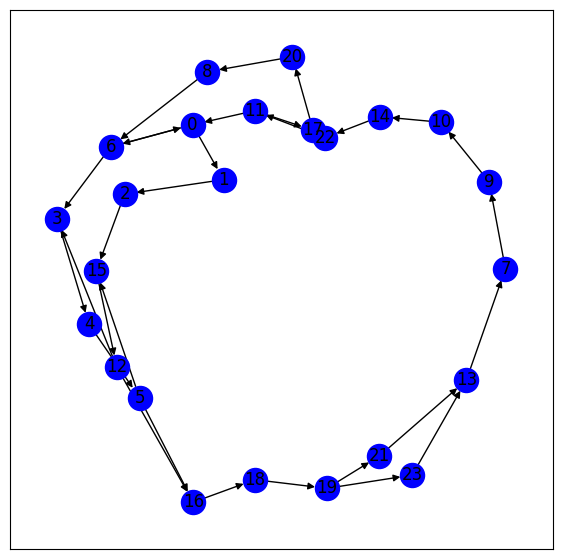

In [33]:
from torch_geometric.utils import to_networkx

G = to_networkx(dataset_with_numpy[0], to_undirected=False)
visualize_graph(G, color='b')

In [147]:
dataset[50].y

tensor([0])

In [16]:
# Option 2: Use the TimeSeriesGraphDataset class
# Convert DataFrame to NumPy array with a specific data type

dataset2 = TimeSeriesGraphDataset(arr, window_size=50, stride=50)

In [17]:
dataset2[0]

Data(x=[50, 1], edge_index=[2, 49], y=[1])

In [16]:
dataset

GraphDataset(91604)

In [18]:
dataset2._indices
dataset2.transform
dataset2.pre_transform

In [ ]:
'''' From GitHub Copilot
Key Attributes of the Data Class:
x: Node feature matrix with shape [num_nodes, num_node_features]. Each row corresponds to the feature vector of a node.
edge_index: Graph connectivity in COO format with shape [2, num_edges]. Each column represents an edge between two nodes.
edge_attr (optional): Edge feature matrix with shape [num_edges, num_edge_features]. Each row corresponds to the feature vector of an edge.
y (optional): Graph-level or node-level labels.
pos (optional): Node position matrix with shape [num_nodes, num_dimensions]. Useful for visualization or spatial graphs.
batch (optional): Batch vector, which assigns each node to a specific graph in a mini-batch.
'''
# label logic - if T in window then label is 1, else 0. Start simple and build out from there
# x = [# nodes, # features], for my case [200, 10]
# edge_index = [2, # edges], for my case [2, 199]
# y = [# nodes, # labels], for my case [200, 1]
# arr = df[['CAN ID', 'Node', 'Edge']].to_numpy()
# maybe a stride of 25 to speed up the process?? At least to start
# stride of 1 was over 10 GBs, so will increase to 25



C:\Users\User1\AppData\Local\Temp\ipykernel_9012\482898013.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\torch\csrc\utils\tensor_new.cpp:277.)
  edge_index = torch.tensor([np.arange(num_nodes - 1), np.arange(1, num_nodes)], dtype=torch.long)


In [25]:
from collections import Counter

# Count the occurrences of each label
label_counts = Counter()
for data in dataset:
    label = data.y.item()
    label_counts[label] += 1

print("Label counts:", label_counts)

Label counts: Counter({0: 201925, 1: 126518})


In [24]:
def train(model, optimizer, train_loader, device):
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data).squeeze()  # Squeeze the output to match the target shape
        loss = F.binary_cross_entropy_with_logits(out, data.y.float())
        loss.backward()
        optimizer.step()

def test(loader, model, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data).squeeze()  # Squeeze the output to match the target shape
            # print(out)
            pred = (out > 0).long()
            correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

In [ ]:

class GATBinaryClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_heads, out_channels):
        super(GATBinaryClassifier, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads)
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=1)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index) # + x  # Skip connection
        x = global_mean_pool(x, batch)  # Readout layer
        x = self.fc(x)
        return x  # Classification layer
    
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # GAT(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Global mean pooling
        x = self.fc(x)
        return x

num_epochs = 2
dataset = dataset2
# dataset = dataset
# Define the split ratio
train_ratio = 0.8
test_ratio = 0.2

# Calculate the number of samples for training and testing
# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# model = AnomalyGNN(num_node_features=50, hidden_channels=64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model = GNN(in_channels=1, hidden_channels=16, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch).squeeze() 
        # print(out)
        # print(batch.y)
        loss = F.binary_cross_entropy_with_logits(out, batch.y.float())
        # loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        

# RPM took 40 mins for 100 epochs. LR of 0.001 works much better than 0.01
# gear took 58 mins for 100 epochs. LR of 0.0005
# DoS took 40ish mins for 100 epochs. LR of 0.0005
# Fuzzy took 31ish mins for 100 epochs. LR of 0.0005

Epoch 1, Loss: 0.6784517168998718
Epoch 2, Loss: 0.6388965249061584


In [25]:
train_acc = test(train_loader, model, device)
test_acc = test(test_loader, model, device)
print(f'Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')

Train Accuracy: 0.5495, Test Accuracy: 0.5513


In [ ]:
#from torchviz import make_dot
# x = torch.randn(1, 3, 224, 224)
# y = model(x)
# make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")

In [ ]:
def model_characteristics(model):
    num_params = sum(p.numel() for p in model.parameters())
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    size_all_mb = (param_size + buffer_size) / 1024**2
    print(f'Number of Parameters: {num_params:.3f}')
    print(f'Model size: {size_all_mb:.3f} MB')

Model size: 0.001 MB


In [160]:
save_dict = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss,
}

torch.save(save_dict, 'Fuzzy_model_checkpoint.pt')

In [ ]:
loaded_dict = torch.load('model_checkpoint.pt')

model.load_state_dict(loaded_dict['model_state_dict'])
optimizer.load_state_dict(loaded_dict['optimizer_state_dict'])
epoch = loaded_dict['epoch']
loss = loaded_dict['loss']